# Predicting total number of bikes people rented in a given hour
Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the U[niversity of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here's what the first five rows look like:
![img](https://dq-content.s3.amazonaws.com/tOZ70lr.png)

## Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, you'll create a few different machine learning models and evaluate their performance.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
#read in the data
bike_rentals = pd.read_csv("bike_rental_hour.csv")
#explore first few rows
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


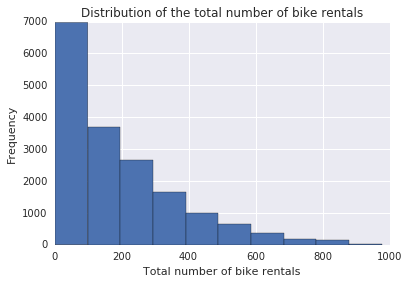

In [3]:
#Make a histogram of the cnt column and take a look ath the distribution
plt.hist(bike_rentals["cnt"])
plt.title('Distribution of the total number of bike rentals')
plt.xlabel('Total number of bike rentals')
plt.ylabel('Frequency')
plt.show()

The distribution is right skewed, we also see that from the 17380 rows of data, almost 7000 have between 0 and 100 bike rentals.

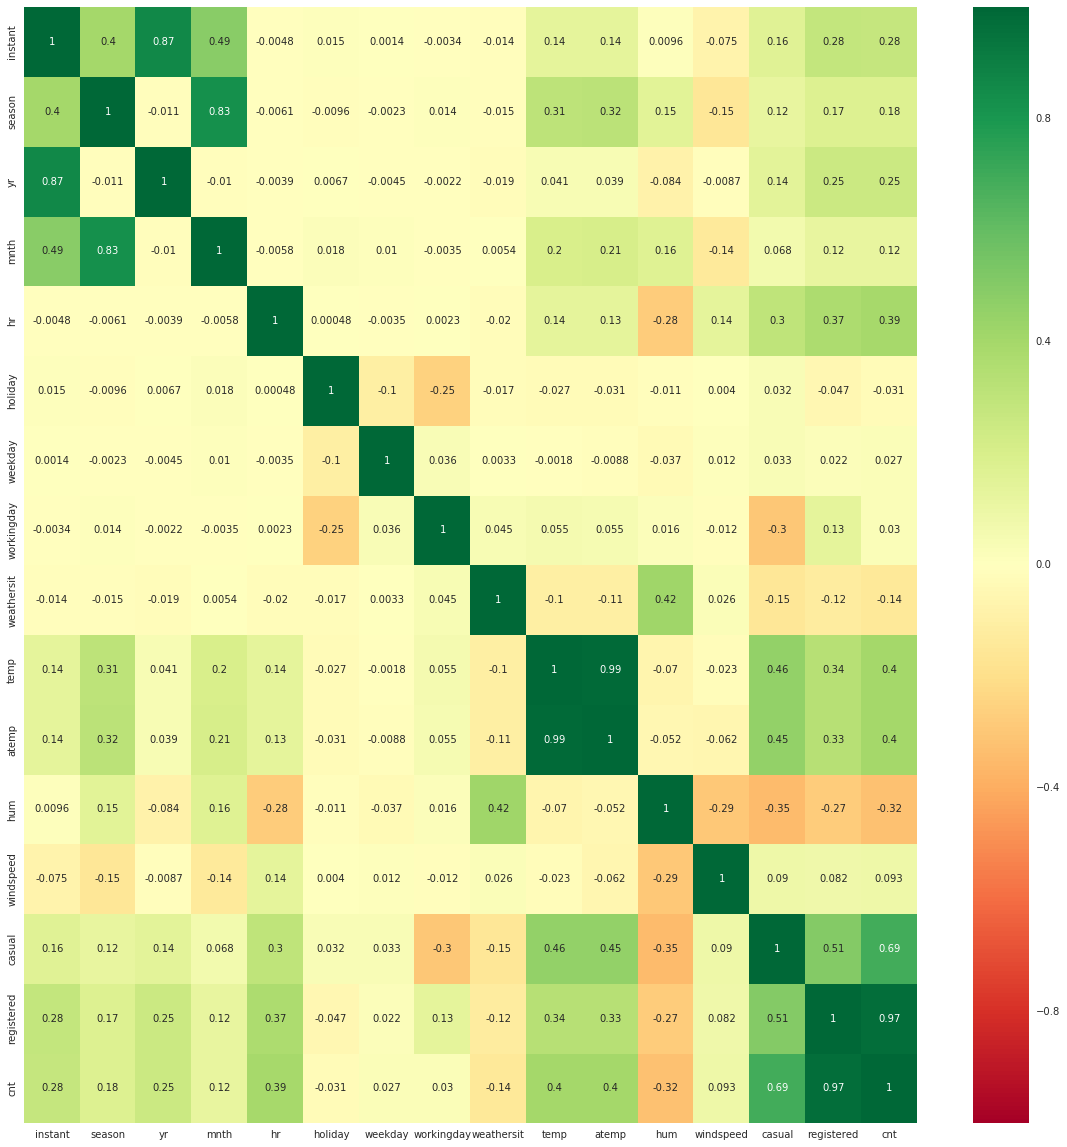

In [4]:
cnt_corr = bike_rentals.corr()['cnt']
top_corr_features = cnt_corr.index
plt.figure(figsize=(20, 20))
sns.heatmap(bike_rentals[top_corr_features].corr(), annot=True, cmap='RdYlGn')

In [5]:
#Use corr to see the correlation between each column with cnt
bike_rentals.corr()["cnt"].reset_index().sort_values(by='cnt')

,index,cnt
11,hum,-0.322911
8,weathersit,-0.142426
5,holiday,-0.030927
6,weekday,0.026900
7,workingday,0.030284
12,windspeed,0.093234
3,mnth,0.120638
1,season,0.178056
2,yr,0.250495
0,instant,0.278379


It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [6]:
#Make sure data is clean
bike_rentals.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [7]:
#function to convert hr by the rule.
def assign_label(hour):
    #1:morning 2:afternoon 3:evening 4:night
    if (hour >= 6) & (hour < 12):
        return 1
    elif (hour >= 12) & (hour < 18):
        return 2
    elif (hour >= 18) & (hour < 24):
        return 3
    else:
        return 4

In [8]:
#apply assign_label function to hr column to create time_label column
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

In [9]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


## Error Metric

Now that the data is cleaned and ready to use, we will select the metrics that we need to analyze the performance of the machine learning algorithms. I have read about this and according to [this post](https://towardsdatascience.com/which-evaluation-metric-should-you-use-in-machine-learning-regression-problems-20cdaef258e) in Towards Data Science the ideal thing to do is use R2, MSE and RMSE. I'm going to report the 3 of them but i'm going to use only RMSE in the analysis

Now that we have the metrics, let's make our train and test samples using the sample method

In [10]:
#Divide the dataset to training set(80% of data) and testing set(remaining).
train = bike_rentals.sample(frac=0.8, random_state=1)

In [11]:
#This line will select any rows in bike_rentals that aren't found in train to be in the testing set
test=bike_rentals[bike_rentals.index.isin(train.index)==0]

Now that we've done some exploration and manipulation, we're ready to apply linear regression to the data. Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with cnt as we can see from corr table above. But we need to ignore the casual and registered columns since cnt column is derived from them.

In [12]:
#Get the features to work on
features = bike_rentals.corr()["cnt"].index
#Our target feature
target="cnt"

In [13]:
#drop the target column and registered, casual
features=features.drop(["registered","casual","cnt"])

In [14]:
#Linear Regression
#Instantiate
lr = LinearRegression()
#fit
lr.fit(train[features], train["cnt"])
#training set
train_pred = lr.predict(train[features])
train_mse = mean_squared_error(train[target], train_pred)
train_rmse = np.sqrt(train_mse)
train_r2score = r2_score(train[target], train_pred)

#testing set
test_pred = lr.predict(test[features])
test_mse = mean_squared_error(test[target], test_pred)
test_rmse = np.sqrt(test_mse)
test_r2score = r2_score(test[target], test_pred)

print("TRAIN ERRORS:")
print("MSE:", train_mse)
print("RMSE:", train_rmse)
print("R2 SCORE:", train_r2score)
print("-"*20)
print("TEST ERRORS:")
print("MSE:", test_mse)
print("RMSE:", test_rmse)
print("R2 SCORE:", test_r2score)

TRAIN ERRORS:
MSE: 17584.747420833704
RMSE: 132.6074938336205
R2 SCORE: 0.4702546683348534
--------------------
TEST ERRORS:
MSE: 17052.124871247568
RMSE: 130.5837848710458
R2 SCORE: 0.46220363568234224


The three error metrics are pretty close to each other. For RMSE value, we have lower value in test set than training set. However, we also see that even if the model isn't overffited, it looks like the model doesn't predict as well as we thought. Let's remove those columns that have a correlation less than 0.3.

In [15]:
feat = ['hum', 'hr', 'atemp', 'temp']

lr = LinearRegression()
lr.fit(train[feat], train[target])

train_pred = lr.predict(train[feat])
train_mse = mean_squared_error(train[target], train_pred)
train_rmse = np.sqrt(train_mse)
train_r2score = r2_score(train[target], train_pred)

test_pred = lr.predict(test[feat])
test_mse = mean_squared_error(test[target], test_pred)
test_rmse = np.sqrt(test_mse)
test_r2score = r2_score(test[target], test_pred)

print("TRAIN ERRORS:")
print("MSE:", train_mse)
print("RMSE:", train_rmse)
print("R2 SCORE:", train_r2score)
print("-"*20)
print("TEST ERRORS:")
print("MSE:", test_mse)
print("RMSE:", test_rmse)
print("R2 SCORE:", test_r2score)

TRAIN ERRORS:
MSE: 22405.67506972855
RMSE: 149.6852533475778
R2 SCORE: 0.32502290269278566
--------------------
TEST ERRORS:
MSE: 21202.319516678905
RMSE: 145.61016282072796
R2 SCORE: 0.3313132271041713


The error increased and the model isn't overfitted or underfitted it simple does not generalize well, wich means that probably the 0.46 is the best r2 score we can get with linear regression, we also can say that linear regression isn't the most adecuate model to use with this dataset.

## Decision Tree Regressor

Now let's use a Decision Tree Regressor to see how well this model works with this data. Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [16]:
clf = DecisionTreeRegressor(random_state=1)
clf.fit(train[features], train[target])

train_pred = clf.predict(train[features])
train_mse = mean_squared_error(train[target], train_pred)
train_rmse = np.sqrt(train_mse)
train_r2score = r2_score(train[target], train_pred)

test_pred = clf.predict(test[features])
test_mse = mean_squared_error(test[target], test_pred)
test_rmse = np.sqrt(test_mse)
test_r2score = r2_score(test[target], test_pred)

print("TRAIN ERRORS:")
print("MSE:", train_mse)
print("RMSE:", train_rmse)
print("R2 SCORE:", train_r2score)
print("-"*20)
print("TEST ERRORS:")
print("MSE:", test_mse)
print("RMSE:", test_rmse)
print("R2 SCORE:", test_r2score)

TRAIN ERRORS:
MSE: 0.0
RMSE: 0.0
R2 SCORE: 1.0
--------------------
TEST ERRORS:
MSE: 3223.4214614499424
RMSE: 56.775183499923116
R2 SCORE: 0.8983385146589968


The errors of the train portion tells us that the model is overfitted, by the way here is a good example of why it's good to use the three metrics instead of only one. Let's experiment with some parameter of the Decision Tree Regressor to see if we can increase it's accuracy.

## Changing min_samples_leaf

The model works with a default number of 1, let's make a for loop and try between 2 and 10 samples

Train Mean MSE: 1074.8811167809797
Test Mean MSE: 2743.108631290733
--------------------
Train Mean RMSE: 32.01800428875172
Test Mean RMSE: 52.36297293837958
--------------------
Train Mean R2SCORE: 0.9676189119989789
Test Mean R2SCORE: 0.9134868023794497


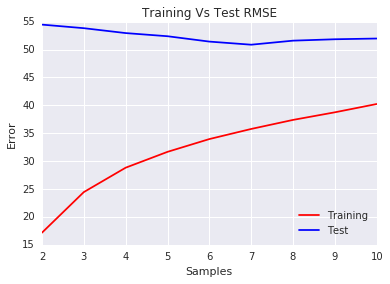

In [17]:
samples = [i for i in range(2,11)]
t_mse = []
t_rmse = []
t_r2score = []
tt_mse = []
tt_rmse = []
tt_r2score = []

for i in samples:
    clf = DecisionTreeRegressor(random_state=1, min_samples_leaf=i)
    clf.fit(train[features], train[target])
    
    #training set
    train_pred = clf.predict(train[features])
    train_mse = mean_squared_error(train[target], train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2score = r2_score(train[target], train_pred)
    t_r2score.append(train_r2score)
    t_rmse.append(train_rmse)
    t_mse.append(train_mse)

    #testing set
    test_pred = clf.predict(test[features])
    test_mse = mean_squared_error(test[target], test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2score = r2_score(test[target], test_pred)
    tt_r2score.append(test_r2score)
    tt_rmse.append(test_rmse)
    tt_mse.append(test_mse)
    
    
print("Train Mean MSE:", np.mean(t_mse))
print("Test Mean MSE:", np.mean(tt_mse))
print('-'*20)
print("Train Mean RMSE:", np.mean(t_rmse))
print("Test Mean RMSE:", np.mean(tt_rmse))
print('-'*20)
print("Train Mean R2SCORE:", np.mean(t_r2score))
print("Test Mean R2SCORE:", np.mean(tt_r2score))

plt.plot(samples, t_rmse, color="red")
plt.plot(samples, tt_rmse, color="blue")
plt.title("Training Vs Test RMSE")
plt.xlabel("Samples")
plt.ylabel("Error")
plt.legend(["Training", "Test"], loc=0)

The model looks overfitted, however the R2score doesn't have a high difference but the RMSE and the graph shows us a huge difference between the values. 

## Changing min_samples_split

Our next step is to change the min_samples_split. The model works with a default number of 2, let's make a for loop and try between 3 and 10 samples.

Train Mean MSE: 379.1299848782209
Test Mean MSE: 2980.9376580714084
--------------------
Train Mean RMSE: 18.56663401401645
Test Mean RMSE: 54.58883989795547
--------------------
Train Mean R2SCORE: 0.9885786053801623
Test Mean R2SCORE: 0.9059860605717516


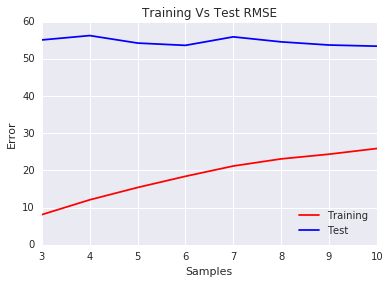

In [18]:
samples = [i for i in range(3,11)]
t_mse = []
t_rmse = []
t_r2score = []
tt_mse = []
tt_rmse = []
tt_r2score = []

for i in samples:
    clf = DecisionTreeRegressor(random_state=1, min_samples_split=i)
    clf.fit(train[features], train[target])
    
    #training set
    train_pred = clf.predict(train[features])
    train_mse = mean_squared_error(train[target], train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2score = r2_score(train[target], train_pred)
    t_r2score.append(train_r2score)
    t_rmse.append(train_rmse)
    t_mse.append(train_mse)

    #testing set
    test_pred = clf.predict(test[features])
    test_mse = mean_squared_error(test[target], test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2score = r2_score(test[target], test_pred)
    tt_r2score.append(test_r2score)
    tt_rmse.append(test_rmse)
    tt_mse.append(test_mse)
    
    
print("Train Mean MSE:", np.mean(t_mse))
print("Test Mean MSE:", np.mean(tt_mse))
print('-'*20)
print("Train Mean RMSE:", np.mean(t_rmse))
print("Test Mean RMSE:", np.mean(tt_rmse))
print('-'*20)
print("Train Mean R2SCORE:", np.mean(t_r2score))
print("Test Mean R2SCORE:", np.mean(tt_r2score))

plt.plot(samples, t_rmse, color="red")
plt.plot(samples, tt_rmse, color="blue")
plt.title("Training Vs Test RMSE")
plt.xlabel("Samples")
plt.ylabel("Error")
plt.legend(["Training", "Test"], loc=0)

The RMSE values tells us that the model is overfitted, however the R2 Score is pretty similar, if we analyze the graph the training error increase with each sample and the test tends to decrease in small gaps. We know that decision trees tend to overfit, so let's build a Random Forest Regressor.

## Random Forest Regressor

We can now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf. Let's train a random forest regressor model with 10 to 100 number of estimators and check the errors.

In [22]:
estimators = [i for i in range(10, 110,5)]
t_mse = []
t_rmse = []
t_r2score = []
tt_mse = []
tt_rmse = []
tt_r2score = []

for i in estimators:
    clf = RandomForestRegressor(n_estimators=i, random_state=1)
    clf.fit(train[features], train[target])
    
    train_pred = clf.predict(train[features])
    train_mse = mean_squared_error(train[target], train_pred)
    t_mse.append(train_mse)
    train_rmse = np.sqrt(train_mse)
    t_rmse.append(train_rmse)
    train_r2score = r2_score(train[target], train_pred)
    t_r2score.append(train_r2score)
    
    test_pred = clf.predict(test[features])
    test_mse = mean_squared_error(test[target], test_pred)
    tt_mse.append(test_mse)
    test_rmse = np.sqrt(test_mse)
    tt_rmse.append(test_rmse)
    test_r2score = r2_score(test[target], test_pred)
    tt_r2score.append(test_r2score)
    
print("Train Mean MSE:", np.mean(t_mse))
print("Test Mean MSE:", np.mean(tt_mse))
print('-'*20)
print("Train Mean RMSE:", np.mean(t_rmse))
print("Test Mean RMSE:", np.mean(tt_rmse))
print('-'*20)
print("Train Mean R2SCORE:", np.mean(t_r2score))
print("Test Mean R2SCORE:", np.mean(tt_r2score))

Train Mean MSE: 246.04847723172279
Test Mean MSE: 1900.7647406666165
--------------------
Train Mean RMSE: 15.669838315640074
Test Mean RMSE: 43.59234293858489
--------------------
Train Mean R2SCORE: 0.9925877222426067
Test Mean R2SCORE: 0.940052962626533


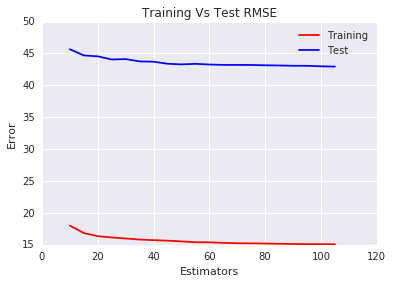

In [23]:
plt.plot(estimators, t_rmse, color="red")
plt.plot(estimators, tt_rmse, color="blue")
plt.title("Training Vs Test RMSE")
plt.xlabel("Estimators")
plt.ylabel("Error")
plt.legend(["Training", "Test"], loc=0)

The model looks overfitted even if both errors tend to decrease with the amount of estimators. However the R2 Score it's pretty close between with a 0.5 points difference, let's try with the same paremeters we used in the Decision Tree Regressor

## Changing min_samples_leaf

The model works with a default number of 1, let's make a for loop and try between 2 and 10 samples and let's use 100 estimators

In [20]:
leafs = [a for a in range(2, 11)]
t_mse = []
t_rmse = []
t_r2score = []
tt_mse = []
tt_rmse = []
tt_r2score = []

for i in leafs:
    clf = RandomForestRegressor(n_estimators=100, min_samples_leaf=i, random_state=1)
    clf.fit(train[features], train[target])
    
    train_pred = clf.predict(train[features])
    train_mse = mean_squared_error(train[target], train_pred)
    t_mse.append(train_mse)
    train_rmse = np.sqrt(train_mse)
    t_rmse.append(train_rmse)
    train_r2score = r2_score(train[target], train_pred)
    t_r2score.append(train_r2score)
    
    test_pred = clf.predict(test[features])
    test_mse = mean_squared_error(test[target], test_pred)
    tt_mse.append(test_mse)
    test_rmse = np.sqrt(test_mse)
    tt_rmse.append(test_rmse)
    test_r2score = r2_score(test[target], test_pred)
    tt_r2score.append(test_r2score)
    
print("Train Mean MSE:", np.mean(t_mse))
print("Test Mean MSE:", np.mean(tt_mse))
print('-'*20)
print("Train Mean RMSE:", np.mean(t_rmse))
print("Test Mean RMSE:", np.mean(tt_rmse))
print('-'*20)
print("Train Mean R2SCORE:", np.mean(t_r2score))
print("Test Mean R2SCORE:", np.mean(tt_r2score))

Train Mean MSE: 1045.7475805162826
Test Mean MSE: 2114.1332952245643
--------------------
Train Mean RMSE: 31.8464889500408
Test Mean RMSE: 45.95216392897786
--------------------
Train Mean R2SCORE: 0.9684965677572206
Test Mean R2SCORE: 0.9333236644442015


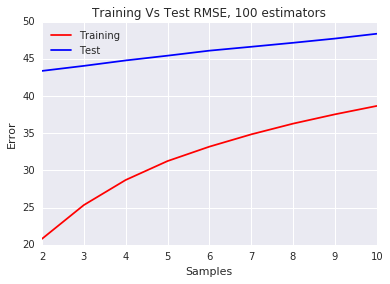

In [21]:
plt.plot(leafs, t_rmse, color="red")
plt.plot(leafs, tt_rmse, color="blue")
plt.title("Training Vs Test RMSE, 100 estimators")
plt.xlabel("Samples")
plt.ylabel("Error")
plt.legend(["Training", "Test"], loc=0)

## Changing min_samples_split

The model works with a default number of 2, let's make a for loop and try between 3 and 10 samples

In [24]:
leafs = [a for a in range(3, 11)]
t_mse = []
t_rmse = []
t_r2score = []
tt_mse = []
tt_rmse = []
tt_r2score = []

for i in leafs:
    clf = RandomForestRegressor(n_estimators=100, min_samples_split=i, random_state=1)
    clf.fit(train[features], train[target])
    
    train_pred = clf.predict(train[features])
    train_mse = mean_squared_error(train[target], train_pred)
    t_mse.append(train_mse)
    train_rmse = np.sqrt(train_mse)
    t_rmse.append(train_rmse)
    train_r2score = r2_score(train[target], train_pred)
    t_r2score.append(train_r2score)
    
    test_pred = clf.predict(test[features])
    test_mse = mean_squared_error(test[target], test_pred)
    tt_mse.append(test_mse)
    test_rmse = np.sqrt(test_mse)
    tt_rmse.append(test_rmse)
    test_r2score = r2_score(test[target], test_pred)
    tt_r2score.append(test_r2score)
    
print("Train Mean MSE:", np.mean(t_mse))
print("Test Mean MSE:", np.mean(tt_mse))
print('-'*20)
print("Train Mean RMSE:", np.mean(t_rmse))
print("Test Mean RMSE:", np.mean(tt_rmse))
print('-'*20)
print("Train Mean R2SCORE:", np.mean(t_r2score))
print("Test Mean R2SCORE:", np.mean(tt_r2score))

Train Mean MSE: 474.1080836790693
Test Mean MSE: 1911.7490639927205
--------------------
Train Mean RMSE: 21.538954325795945
Test Mean RMSE: 43.72139362339111
--------------------
Train Mean R2SCORE: 0.9857173641438752
Test Mean R2SCORE: 0.9397065348825497


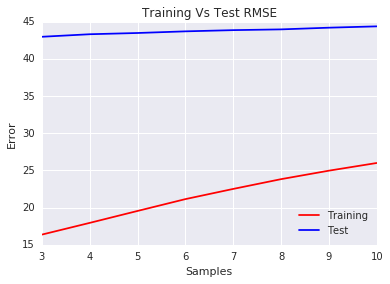

In [26]:
plt.plot(leafs, t_rmse, color="red")
plt.plot(leafs, tt_rmse, color="blue")
plt.title("Training Vs Test RMSE")
plt.xlabel("Samples")
plt.ylabel("Error")
plt.legend(["Training", "Test"], loc=0)

## Final Analysis

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



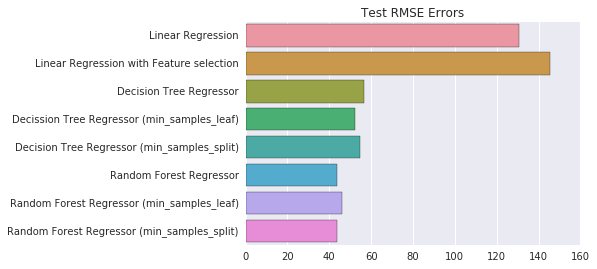

In [27]:
test_rmse_errors = [130.5837848710458, 145.61016282072796, 56.775183499923116,
                   52.36297293837958, 54.58883989795547, 43.59234293858489,
                    45.95216392897786,  43.72139362339111]

models = ['Linear Regression', 'Linear Regression with Feature selection',
         'Decision Tree Regressor', 'Decission Tree Regressor (min_samples_leaf)',
         'Decision Tree Regressor (min_samples_split)', 'Random Forest Regressor',
         'Random Forest Regressor (min_samples_leaf)',
          'Random Forest Regressor (min_samples_split)']

ax = plt.subplot()
sns.barplot(test_rmse_errors, models, orient='h')
plt.title("Test RMSE Errors")

It's clear that the Random Forest Regressor have least RMSE values. 

In Decision Trees the experiments in the parameters helped to reduce the RMSE value, however in the Random Forest there was a slightly increase in the values. The feature selection in Linear regression did not help at all.

Some of the models were considered overfitted (if we see the MSE and RMSE) and most of them were impossible to reduce. It's strange that the R2 scores did not show signs of overfit. 